In [ ]:
from google.colab import drive 
drive.mount('/content/gdrive/')

%cd /content/gdrive/My\ Drive/TESIS/autism-master/

Mounted at /content/gdrive/
/content/gdrive/My Drive/TESIS/autism-master


In [ ]:
%%capture
import os
import sys
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_validate
!{sys.executable} -m pip install https://api.github.com/repos/paris-saclay-cds/ramp-workflow/zipball/master
!{sys.executable} -m pip install scikit-learn seaborn nilearn
from problem import get_cv
from download_data import fetch_fmri_time_series
from problem import get_train_data
!pip install ripser
from ripser import ripser
from persim import plot_diagrams
!pip install tensorflow_addons  
!pip install gudhi
import pickle as pkl
from sklearn.ensemble import *
from sklearn.svm import *
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV, KFold, ShuffleSplit
from tensorflow import random_uniform_initializer as rui
import gudhi.representations as tda
import tensorflow as tf
import os.path
import itertools
import h5py
import tensorflow_addons  as tfa
import gudhi              as gd
from scipy.sparse           import csgraph
from scipy.io               import loadmat
from scipy.linalg           import eigh
from sklearn.preprocessing  import LabelEncoder, OneHotEncoder
from sklearn.cluster import KMeans
import pandas as pd
import seaborn as sns
# Reduccion dimensionalidad
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
!pip install git+https://github.com/MathieuCarriere/perslay
!pip install git+https://github.com/MathieuCarriere/sklearn-tda
from perslay import PerslayModel
from scipy.stats import beta
!pip install nilearn
from nilearn.connectome import ConnectivityMeasure
import matplotlib.pyplot as plt

In [ ]:
data_train, labels_train = get_train_data()

In [ ]:
data_train.head()

,participants_site,participants_sex,participants_age,anatomy_lh_bankssts_area,anatomy_lh_caudalanteriorcingulate_area,anatomy_lh_caudalmiddlefrontal_area,anatomy_lh_cuneus_area,anatomy_lh_entorhinal_area,anatomy_lh_fusiform_area,anatomy_lh_inferiorparietal_area,anatomy_lh_inferiortemporal_area,anatomy_lh_isthmuscingulate_area,anatomy_lh_lateraloccipital_area,anatomy_lh_lateralorbitofrontal_area,anatomy_lh_lingual_area,anatomy_lh_medialorbitofrontal_area,anatomy_lh_middletemporal_area,anatomy_lh_parahippocampal_area,anatomy_lh_paracentral_area,anatomy_lh_parsopercularis_area,anatomy_lh_parsorbitalis_area,anatomy_lh_parstriangularis_area,anatomy_lh_pericalcarine_area,anatomy_lh_postcentral_area,anatomy_lh_posteriorcingulate_area,anatomy_lh_precentral_area,anatomy_lh_precuneus_area,anatomy_lh_rostralanteriorcingulate_area,anatomy_lh_rostralmiddlefrontal_area,anatomy_lh_superiorfrontal_area,anatomy_lh_superiorparietal_area,anatomy_lh_superiortemporal_area,anatomy_lh_supramarginal_area,anatomy_lh_frontalpole_area,anatomy_lh_temporalpole_area,anatomy_lh_transversetemporal_area,anatomy_lh_insula_area,anatomy_lh_WhiteSurfArea_area,anatomy_rh_bankssts_area,anatomy_rh_caudalanteriorcingulate_area,...,anatomy_Right-non-WM-hypointensities,anatomy_Optic-Chiasm,anatomy_CC_Posterior,anatomy_CC_Mid_Posterior,anatomy_CC_Central,anatomy_CC_Mid_Anterior,anatomy_CC_Anterior,anatomy_BrainSegVol,anatomy_BrainSegVolNotVentSurf,anatomy_lhCortexVol,anatomy_rhCortexVol,anatomy_CortexVol,anatomy_lhCerebralWhiteMatterVol,anatomy_rhCerebralWhiteMatterVol,anatomy_CerebralWhiteMatterVol,anatomy_SubCortGrayVol,anatomy_TotalGrayVol,anatomy_SupraTentorialVol,anatomy_SupraTentorialVolNotVent,anatomy_SupraTentorialVolNotVentVox,anatomy_MaskVol,anatomy_BrainSegVol-to-eTIV,anatomy_MaskVol-to-eTIV,anatomy_lhSurfaceHoles,anatomy_rhSurfaceHoles,anatomy_SurfaceHoles,anatomy_EstimatedTotalIntraCranialVol,anatomy_eTIV,anatomy_BrainSegVolNotVent,anatomy_select,fmri_basc064,fmri_basc122,fmri_basc197,fmri_craddock_scorr_mean,fmri_harvard_oxford_cort_prob_2mm,fmri_motions,fmri_msdl,fmri_power_2011,fmri_select,repetition_time
subject_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1932355398536124106,5,F,9.301370,977.0,427.0,1884.0,1449.0,463.0,2790.0,4091.0,3305.0,897.0,4406.0,2840.0,2571.0,1693.0,2953.0,669.0,1251.0,1508.0,615.0,1380.0,1267.0,3956.0,926.0,4490.0,4097.0,685.0,5423.0,7040.0,6391.0,3471.0,4013.0,225.0,478.0,415.0,2020.0,81059.6,850.0,534.0,...,0.0,263.7,757.6,462.6,446.1,400.8,819.5,1073332.0,1.059829e+06,262826.404548,261285.128186,524111.532734,183110.242509,181879.257294,364989.499803,53149.0,673569.532734,9.548540e+05,9.433810e+05,941139.0,1375171.0,0.840976,1.077472,30.0,31.0,61.0,1.276294e+06,1.276294e+06,1058903.0,1,./data/fmri/basc064/1932355398536124106/run_1/...,./data/fmri/basc122/1932355398536124106/run_1/...,./data/fmri/basc197/1932355398536124106/run_1/...,./data/fmri/craddock_scorr_mean/19323553985361...,./data/fmri/harvard_oxford_cort_prob_2mm/19323...,./data/fmri/motions/1932355398536124106/run_1/...,./data/fmri/msdl/1932355398536124106/run_1/193...,./data/fmri/power_2011/1932355398536124106/run...,1,2.5
5174041730092253771,19,M,29.000000,1279.0,730.0,2419.0,1611.0,467.0,3562.0,5380.0,3555.0,1155.0,5611.0,2867.0,3412.0,1963.0,4112.0,670.0,1545.0,2342.0,878.0,1961.0,1587.0,4288.0,1330.0,5073.0,4378.0,999.0,6376.0,7851.0,5794.0,4484.0,4689.0,249.0,490.0,448.0,2708.0,96260.5,925.0,911.0,...,0.0,163.0,902.0,603.0,527.4,507.9,1044.4,1349407.0,1.329346e+06,284683.699493,287393.006096,572076.705589,268366.061339,271307.630193,539673.691532,70140.0,759505.705589,1.199671e+06,1.183773e+06,1181796.0,1807924.0,0.771229,1.033285,45.0,54.0,99.0,1.749685e+06,1.749685e+06,1329340.0,1,./data/fmri/basc064/5174041730092253771/run_1/...,./data/fmri/basc122/5174041730092253771/run_1/...,./data/fmri/basc197/5174041730092253771/run_1/...,./data/fmri/craddock_scorr_mean/51740417300922...,./data/fmri/harvard_oxford_cort_prob_2mm/5

In [ ]:
data_train[['participants_sex']] = [1 if k[0]=="F" else 0 for k in data_train[["participants_sex"]].values]

In [ ]:
data_train.head()

,participants_site,participants_sex,participants_age,anatomy_lh_bankssts_area,anatomy_lh_caudalanteriorcingulate_area,anatomy_lh_caudalmiddlefrontal_area,anatomy_lh_cuneus_area,anatomy_lh_entorhinal_area,anatomy_lh_fusiform_area,anatomy_lh_inferiorparietal_area,anatomy_lh_inferiortemporal_area,anatomy_lh_isthmuscingulate_area,anatomy_lh_lateraloccipital_area,anatomy_lh_lateralorbitofrontal_area,anatomy_lh_lingual_area,anatomy_lh_medialorbitofrontal_area,anatomy_lh_middletemporal_area,anatomy_lh_parahippocampal_area,anatomy_lh_paracentral_area,anatomy_lh_parsopercularis_area,anatomy_lh_parsorbitalis_area,anatomy_lh_parstriangularis_area,anatomy_lh_pericalcarine_area,anatomy_lh_postcentral_area,anatomy_lh_posteriorcingulate_area,anatomy_lh_precentral_area,anatomy_lh_precuneus_area,anatomy_lh_rostralanteriorcingulate_area,anatomy_lh_rostralmiddlefrontal_area,anatomy_lh_superiorfrontal_area,anatomy_lh_superiorparietal_area,anatomy_lh_superiortemporal_area,anatomy_lh_supramarginal_area,anatomy_lh_frontalpole_area,anatomy_lh_temporalpole_area,anatomy_lh_transversetemporal_area,anatomy_lh_insula_area,anatomy_lh_WhiteSurfArea_area,anatomy_rh_bankssts_area,anatomy_rh_caudalanteriorcingulate_area,...,anatomy_Right-non-WM-hypointensities,anatomy_Optic-Chiasm,anatomy_CC_Posterior,anatomy_CC_Mid_Posterior,anatomy_CC_Central,anatomy_CC_Mid_Anterior,anatomy_CC_Anterior,anatomy_BrainSegVol,anatomy_BrainSegVolNotVentSurf,anatomy_lhCortexVol,anatomy_rhCortexVol,anatomy_CortexVol,anatomy_lhCerebralWhiteMatterVol,anatomy_rhCerebralWhiteMatterVol,anatomy_CerebralWhiteMatterVol,anatomy_SubCortGrayVol,anatomy_TotalGrayVol,anatomy_SupraTentorialVol,anatomy_SupraTentorialVolNotVent,anatomy_SupraTentorialVolNotVentVox,anatomy_MaskVol,anatomy_BrainSegVol-to-eTIV,anatomy_MaskVol-to-eTIV,anatomy_lhSurfaceHoles,anatomy_rhSurfaceHoles,anatomy_SurfaceHoles,anatomy_EstimatedTotalIntraCranialVol,anatomy_eTIV,anatomy_BrainSegVolNotVent,anatomy_select,fmri_basc064,fmri_basc122,fmri_basc197,fmri_craddock_scorr_mean,fmri_harvard_oxford_cort_prob_2mm,fmri_motions,fmri_msdl,fmri_power_2011,fmri_select,repetition_time
subject_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1932355398536124106,5,1,9.301370,977.0,427.0,1884.0,1449.0,463.0,2790.0,4091.0,3305.0,897.0,4406.0,2840.0,2571.0,1693.0,2953.0,669.0,1251.0,1508.0,615.0,1380.0,1267.0,3956.0,926.0,4490.0,4097.0,685.0,5423.0,7040.0,6391.0,3471.0,4013.0,225.0,478.0,415.0,2020.0,81059.6,850.0,534.0,...,0.0,263.7,757.6,462.6,446.1,400.8,819.5,1073332.0,1.059829e+06,262826.404548,261285.128186,524111.532734,183110.242509,181879.257294,364989.499803,53149.0,673569.532734,9.548540e+05,9.433810e+05,941139.0,1375171.0,0.840976,1.077472,30.0,31.0,61.0,1.276294e+06,1.276294e+06,1058903.0,1,./data/fmri/basc064/1932355398536124106/run_1/...,./data/fmri/basc122/1932355398536124106/run_1/...,./data/fmri/basc197/1932355398536124106/run_1/...,./data/fmri/craddock_scorr_mean/19323553985361...,./data/fmri/harvard_oxford_cort_prob_2mm/19323...,./data/fmri/motions/1932355398536124106/run_1/...,./data/fmri/msdl/1932355398536124106/run_1/193...,./data/fmri/power_2011/1932355398536124106/run...,1,2.5
5174041730092253771,19,0,29.000000,1279.0,730.0,2419.0,1611.0,467.0,3562.0,5380.0,3555.0,1155.0,5611.0,2867.0,3412.0,1963.0,4112.0,670.0,1545.0,2342.0,878.0,1961.0,1587.0,4288.0,1330.0,5073.0,4378.0,999.0,6376.0,7851.0,5794.0,4484.0,4689.0,249.0,490.0,448.0,2708.0,96260.5,925.0,911.0,...,0.0,163.0,902.0,603.0,527.4,507.9,1044.4,1349407.0,1.329346e+06,284683.699493,287393.006096,572076.705589,268366.061339,271307.630193,539673.691532,70140.0,759505.705589,1.199671e+06,1.183773e+06,1181796.0,1807924.0,0.771229,1.033285,45.0,54.0,99.0,1.749685e+06,1.749685e+06,1329340.0,1,./data/fmri/basc064/5174041730092253771/run_1/...,./data/fmri/basc122/5174041730092253771/run_1/...,./data/fmri/basc197/5174041730092253771/run_1/...,./data/fmri/craddock_scorr_mean/51740417300922...,./data/fmri/harvard_oxford_cort_prob_2mm/5

In [ ]:
data.head()

,anatomy_lh_bankssts_area,anatomy_lh_caudalanteriorcingulate_area,anatomy_lh_caudalmiddlefrontal_area,anatomy_lh_cuneus_area,anatomy_lh_entorhinal_area,anatomy_lh_fusiform_area,anatomy_lh_inferiorparietal_area,anatomy_lh_inferiortemporal_area,anatomy_lh_isthmuscingulate_area,anatomy_lh_lateraloccipital_area,anatomy_lh_lateralorbitofrontal_area,anatomy_lh_lingual_area,anatomy_lh_medialorbitofrontal_area,anatomy_lh_middletemporal_area,anatomy_lh_parahippocampal_area,anatomy_lh_paracentral_area,anatomy_lh_parsopercularis_area,anatomy_lh_parsorbitalis_area,anatomy_lh_parstriangularis_area,anatomy_lh_pericalcarine_area,anatomy_lh_postcentral_area,anatomy_lh_posteriorcingulate_area,anatomy_lh_precentral_area,anatomy_lh_precuneus_area,anatomy_lh_rostralanteriorcingulate_area,anatomy_lh_rostralmiddlefrontal_area,anatomy_lh_superiorfrontal_area,anatomy_lh_superiorparietal_area,anatomy_lh_superiortemporal_area,anatomy_lh_supramarginal_area,anatomy_lh_frontalpole_area,anatomy_lh_temporalpole_area,anatomy_lh_transversetemporal_area,anatomy_lh_insula_area,anatomy_lh_WhiteSurfArea_area,anatomy_rh_bankssts_area,anatomy_rh_caudalanteriorcingulate_area,anatomy_rh_caudalmiddlefrontal_area,anatomy_rh_cuneus_area,anatomy_rh_entorhinal_area,...,anatomy_Right-Amygdala,anatomy_Right-Accumbens-area,anatomy_Right-VentralDC,anatomy_Right-vessel,anatomy_Right-choroid-plexus,anatomy_5th-Ventricle,anatomy_WM-hypointensities,anatomy_Left-WM-hypointensities,anatomy_Right-WM-hypointensities,anatomy_non-WM-hypointensities,anatomy_Left-non-WM-hypointensities,anatomy_Right-non-WM-hypointensities,anatomy_Optic-Chiasm,anatomy_CC_Posterior,anatomy_CC_Mid_Posterior,anatomy_CC_Central,anatomy_CC_Mid_Anterior,anatomy_CC_Anterior,anatomy_BrainSegVol,anatomy_BrainSegVolNotVentSurf,anatomy_lhCortexVol,anatomy_rhCortexVol,anatomy_CortexVol,anatomy_lhCerebralWhiteMatterVol,anatomy_rhCerebralWhiteMatterVol,anatomy_CerebralWhiteMatterVol,anatomy_SubCortGrayVol,anatomy_TotalGrayVol,anatomy_SupraTentorialVol,anatomy_SupraTentorialVolNotVent,anatomy_SupraTentorialVolNotVentVox,anatomy_MaskVol,anatomy_BrainSegVol-to-eTIV,anatomy_MaskVol-to-eTIV,anatomy_lhSurfaceHoles,anatomy_rhSurfaceHoles,anatomy_SurfaceHoles,anatomy_EstimatedTotalIntraCranialVol,anatomy_eTIV,anatomy_BrainSegVolNotVent
subject_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1932355398536124106,977.0,427.0,1884.0,1449.0,463.0,2790.0,4091.0,3305.0,897.0,4406.0,2840.0,2571.0,1693.0,2953.0,669.0,1251.0,1508.0,615.0,1380.0,1267.0,3956.0,926.0,4490.0,4097.0,685.0,5423.0,7040.0,6391.0,3471.0,4013.0,225.0,478.0,415.0,2020.0,81059.6,850.0,534.0,2083.0,1629.0,478.0,...,1255.3,604.7,3540.8,13.5,618.4,0.0,532.4,0.0,0.0,0.0,0.0,0.0,263.7,757.6,462.6,446.1,400.8,819.5,1073332.0,1.059829e+06,262826.404548,261285.128186,524111.532734,183110.242509,181879.257294,364989.499803,53149.0,673569.532734,9.548540e+05,9.433810e+05,941139.0,1375171.0,0.840976,1.077472,30.0,31.0,61.0,1.276294e+06,1.276294e+06,1058903.0
5174041730092253771,1279.0,730.0,2419.0,1611.0,467.0,3562.0,5380.0,3555.0,1155.0,5611.0,2867.0,3412.0,1963.0,4112.0,670.0,1545.0,2342.0,878.0,1961.0,1587.0,4288.0,1330.0,5073.0,4378.0,999.0,6376.0,7851.0,5794.0,4484.0,4689.0,249.0,490.0,448.0,2708.0,96260.5,925.0,911.0,2464.0,1633.0,407.0,...,2254.2,740.5,5045.2,51.9,610.1,0.0,696.8,0.0,0.0,0.0,0.0,0.0,163.0,902.0,603.0,527.4,507.9,1044.4,1349407.0,1.329346e+06,284683.699493,287393.006096,572076.705589,268366.061339,271307.630193,539673.691532,70140.0,759505.705589,1.199671e+06,1.183773e+06,1181796.0,1807924.0,0.771229,1.033285,45.0,54.0,99.0,1.749685e+06,1.749685e+06,1329340.0
10219322676643534800,926.0,446.0,1897.0,2135.0,570.0,3064.0,4834.0,2602.0,1171.0,6395.0,2699.0,3850.0,2009.0,3239.0,660.0,1382.0,1831.0,859.0,1497.0,1771.0,3976.0,1156.0,4953.0,3667.0,742.0,5529.0,6239.0,5947.0,4134.0,4044.0,289.0,381.0,509.0,2331.0,87729.7,817.0,600.0,1845.0,1126.0,581.0,...,1526.6,458.8,4024.4,15.5,437.7,0.0,722.2,0.0,0.0,0.0,0.0,0.0,205.0,885.

In [ ]:
data = data_train.drop(['participants_site'	,
                        'anatomy_select',	
                        'fmri_basc064',	
                        'fmri_basc122',
                        'fmri_basc197',	
                        'fmri_craddock_scorr_mean',	
                        'fmri_harvard_oxford_cort_prob_2mm',
                        'fmri_motions'	,
                        'fmri_msdl',	
                        'fmri_power_2011'	,
                        'fmri_select'	,
                        'repetition_time'], axis=1)

In [ ]:
def _load_fmri(fmri_filenames):
    """Load time-series extracted from the fMRI using a specific atlas."""
    return np.array([pd.read_csv(subject_filename,
                                 header=None).values
                     for subject_filename in fmri_filenames])

In [ ]:
import numpy as np

In [ ]:
muestra = data_train[['fmri_basc064']].iloc[1].values[0]
try_fmri = _load_fmri([muestra])
fmri_muestra = pd.DataFrame(try_fmri[0])
fmri_muestra = fmri_muestra.T
fmri_melted = pd.melt(fmri_muestra)
fmri_melted['Clase'] = 0

In [ ]:
labels_train[1:10]

array([0, 1, 1, 1, 1, 0, 0, 0, 0])

In [ ]:
muestra2 = data_train[['fmri_basc064']].iloc[2].values[0]
try_fmri2 = _load_fmri([muestra2])
fmri_muestra2 = pd.DataFrame(try_fmri2[0])
fmri_muestra2 = fmri_muestra2.T
fmri_melted2 = pd.melt(fmri_muestra2)
fmri_melted2['Clase'] = 1

In [ ]:
fmri_melted2.head()

,variable,value,Clase
0,0,-4.838083,1
1,0,-17.912607,1
2,0,-13.063179,1
3,0,17.327632,1
4,0,-7.035201,1


In [ ]:
fmri_melted.head()

,variable,value,Clase
0,0,-0.362154,0
1,0,-19.494065,0
2,0,-6.034837,0
3,0,-0.183885,0
4,0,-4.841950,0


In [ ]:
melted_full = pd.concat([fmri_melted,fmri_melted2])

In [ ]:
melted_full.head()

,variable,value,Clase
0,0,-0.362154,0
1,0,-19.494065,0
2,0,-6.034837,0
3,0,-0.183885,0
4,0,-4.841950,0


In [ ]:
melted_full.shape

(15360, 3)

In [ ]:
melted_full.columns = ['Tiempo', 'Actividad', 'Clase']

In [ ]:
import seaborn as sns

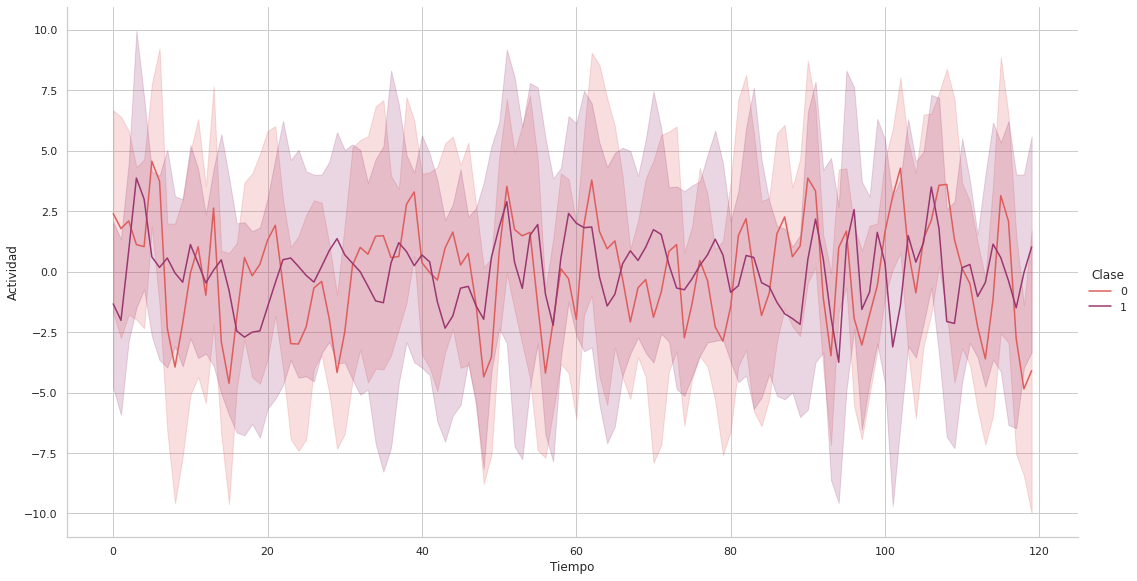

In [ ]:
sns.set_style("whitegrid")
sns.relplot(x="Tiempo", y="Actividad",  hue="Clase",
            palette="flare",
            dashes=False, markers=True, kind="line", data=melted_full, height=8, aspect=15/8)
plt.show()

In [ ]:
data.shape

(1127, 209)

In [ ]:
covar_matrix = PCA(n_components = 5)
covar_matrix.fit(data)
variance = covar_matrix.explained_variance_ratio_ #calculate variance ratios

var=np.cumsum(np.round(covar_matrix.explained_variance_ratio_, decimals=3)*100)

In [ ]:
index = [1,2,3,4,5]
vardf = pd.DataFrame({'var':var})
vardf.index = index

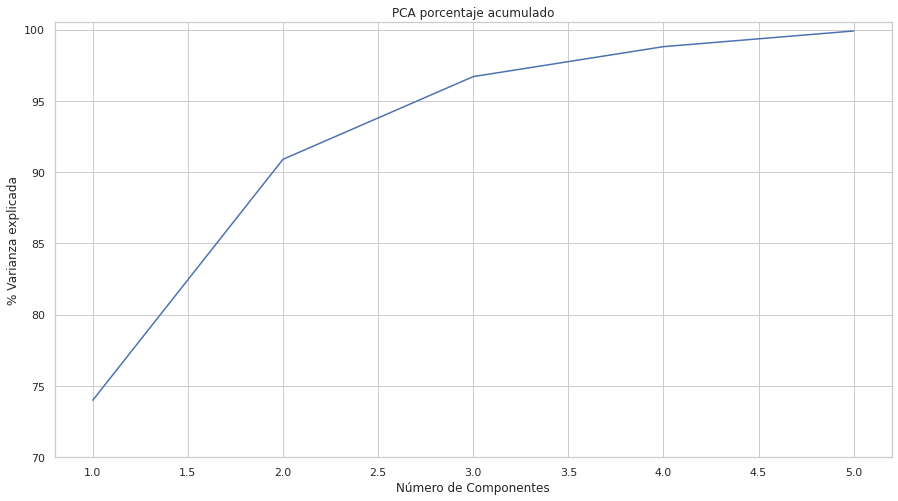

In [ ]:
plt.ylabel('% Varianza explicada')
plt.xlabel('Número de Componentes')
plt.title('PCA porcentaje acumulado')
plt.ylim(70,100.5)
plt.style.context('seaborn-whitegrid')


plt.plot(vardf)

In [ ]:
!pip install umap-learn[plot]
!pip install holoviews ==1.12.7
!pip install -U ipykernel

     |████████████████████████████████| 80 kB 2.8 MB/s 
     |████████████████████████████████| 1.1 MB 40.8 MB/s 
     |████████████████████████████████| 15.8 MB 611 bytes/s 
     |████████████████████████████████| 76 kB 5.4 MB/s 
     |████████████████████████████████| 766 kB 66.6 MB/s 
     |████████████████████████████████| 118 kB 77.2 MB/s 
     |████████████████████████████████| 1.0 MB 53.0 MB/s 
     |████████████████████████████████| 722 kB 69.6 MB/s 
     |████████████████████████████████| 722 kB 51.6 MB/s 
     |████████████████████████████████| 715 kB 30.7 MB/s 
     |████████████████████████████████| 705 kB 59.1 MB/s 
     |████████████████████████████████| 699 kB 42.3 MB/s 
     |████████████████████████████████| 696 kB 38.6 MB/s 
     |████████████████████████████████| 684 kB 70.7 MB/s 
     |████████████████████████████████| 679 kB 71.7 MB/s 
     |████████████████████████████████| 675 kB 60.5 MB/s 
     |████████████████████████████████| 675 kB 45.3 MB/s 
     |█████████

ERROR: Invalid requirement: '==1.12.7'
     |████████████████████████████████| 122 kB 33.1 MB/s 
     |████████████████████████████████| 786 kB 34.8 MB/s 
     |████████████████████████████████| 368 kB 46.7 MB/s 
  Attempting uninstall: prompt-toolkit
    Found existing installation: prompt-toolkit 1.0.18
    Uninstalling prompt-toolkit-1.0.18:
      Successfully uninstalled prompt-toolkit-1.0.18
  Attempting uninstall: ipython
    Found existing installation: ipython 5.5.0
    Uninstalling ipython-5.5.0:
      Successfully uninstalled ipython-5.5.0
  Attempting uninstall: importlib-metadata
    Found existing installation: importlib-metadata 4.6.1
    Uninstalling importlib-metadata-4.6.1:
      Successfully uninstalled importlib-metadata-4.6.1
  Attempting uninstall: ipykernel
    Found existing installation: ipykernel 4.10.1
    Uninstalling ipykernel-4.10.1:
      Successfully uninstalled ipykernel-4.10.1
ERROR: pip's dependency resolver does not currently take into account all the

In [ ]:

import umap
import umap.plot

In [ ]:
umap_op = umap.UMAP()
data_umap = umap_op.fit_transform(data)

/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


In [ ]:
data_umap[1]

array([0.09175584, 7.1126013 ], dtype=float32)

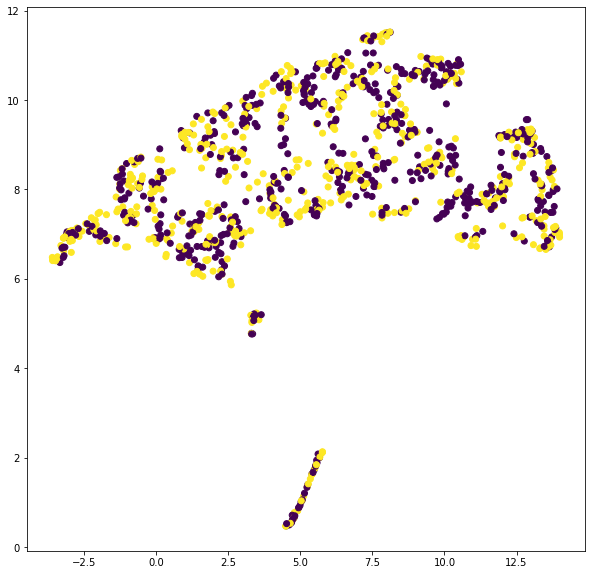

In [ ]:
plt.figure(figsize=(10,10))
plt.scatter(data_umap[:,0], data_umap[:,1], c=labels_train)

plt.show()